## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os

# Set paths
labels_path = '/datasets/faces/labels.csv'
images_path = '/datasets/faces/final_files/'

# Load labels
labels = pd.read_csv(labels_path)

# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator flow
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=images_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

Total number of images: 7591


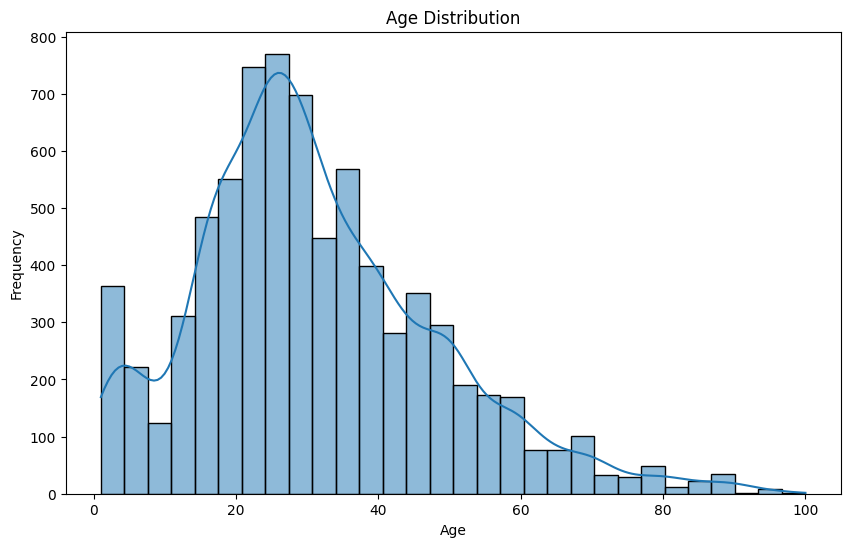

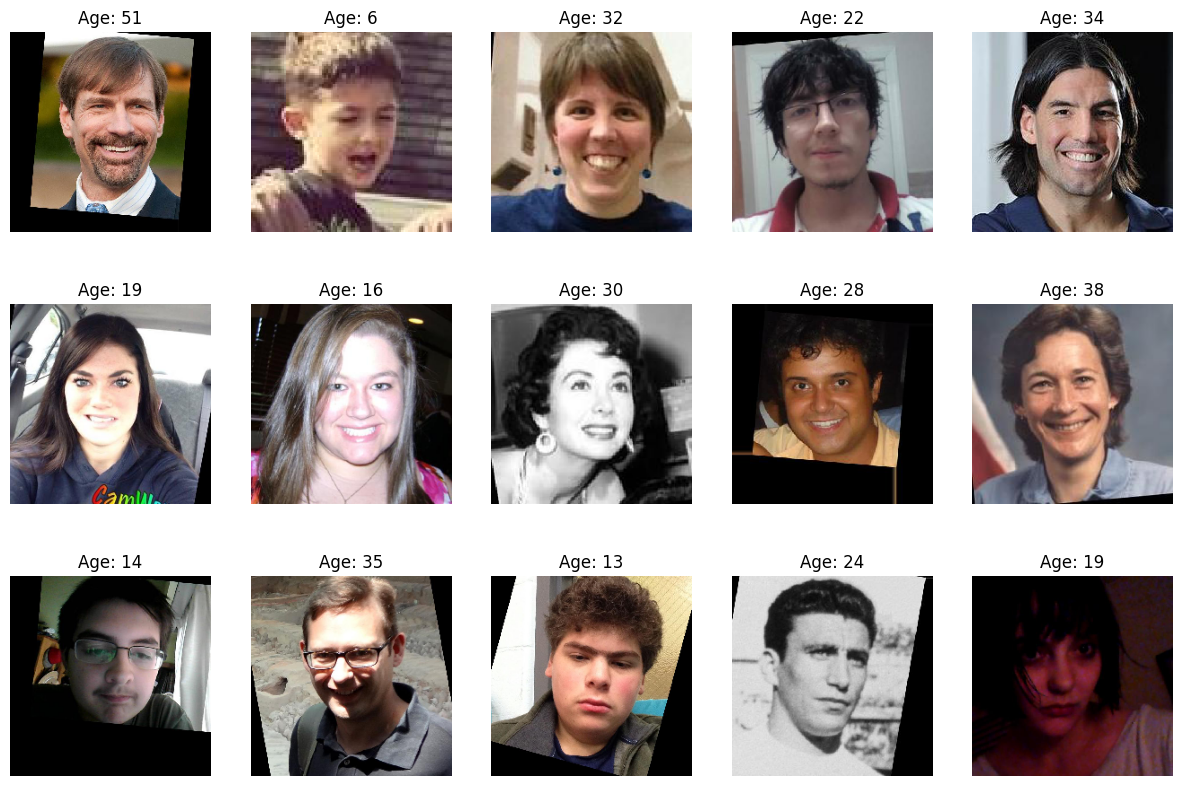

In [2]:
# Check the size of the dataset
print(f'Total number of images: {labels.shape[0]}')

# Plot age distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Function to display sample images
def display_sample_images(labels, images_path, num_samples=15):
    sample_labels = labels.sample(num_samples)
    plt.figure(figsize=(15, 10))
    for i, row in enumerate(sample_labels.iterrows()):
        ax = plt.subplot(3, 5, i + 1)
        img = image.load_img(os.path.join(images_path, row[1]['file_name']), target_size=(224, 224))
        plt.imshow(img)
        plt.title(f"Age: {row[1]['real_age']}")
        plt.axis('off')
    plt.show()

# Display sample images
display_sample_images(labels, images_path)

### Findings

The total number of images is 7,591. The age distribution histogram shows a wide range of ages with a noticeable concentration around the 20-30 age range. There are fewer samples in the extreme age ranges (very young and very old). The sample images show a good variety in terms of age, gender, and image quality. Some images have different orientations and backgrounds, which might affect the model's performance and may require augmentation or preprocessing.

## Modelling

In [3]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)# place your code here

    return train_gen_flow

In [5]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)# place your code here

    return test_gen_flow

In [6]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])# place your code here

    return model

In [7]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = train_data.n // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.n // test_data.batch_size
    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_data,
        validation_steps=validation_steps,
        epochs=epochs,
        verbose=1)# place your code here

    return model, history

## Prepare the Script to Run on the GPU Platform

In [8]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

## Conclusions

The model achieved a final training MAE of 3.1785 and a validation MAE of 7.6512. This indicates that, on average, the model's age predictions are off by approximately 7.65 years on the validation set.
The MAE on the validation set shows the model is performing reasonably well but has some room for improvement.
The training loss and MAE consistently decreased over the epochs, suggesting that the model was effectively learning.
The validation loss and MAE show a decreasing trend initially but fluctuate in the later epochs, indicating potential overfitting or variability in the validation set.
The divergence between training and validation MAE in later epochs suggests that the model might be overfitting to the training data.
This can be mitigated by incorporating techniques like early stopping, dropout, and data augmentation.
The model shows promising performance with a validation MAE below the target threshold, indicating its potential effectiveness in estimating ages from images.
Further tuning and experimentation can help enhance the model's accuracy and reduce overfitting, leading to better generalization on unseen data.